In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras as keras

from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense

In [ ]:
import gym

In [ ]:
class DuelingDQN(keras.Model):


  """Actor (Policy) Model."""
  """Initialize parameters and build model.
        Params
        ======
            Input (int): Dimension of states
            actions (int): Dimension of actions
        """
  def __init__(self, num_actions):
        super(DuelingDQN, self).__init__()
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(128, activation='relu')
        # Value stream
        self.V = Dense(1, activation=None)
        # Advantage stream
        self.A = Dense(num_actions, activation=None)

  def call(self, state):
      x = self.dense1(state)
      x = self.dense2(x)
      V = self.V(x)
      A = self.A(x)
      avg_A = tf.math.reduce_mean(A, axis=1, keepdims=True)
      Q = (V + (A - avg_A))
      return Q, A
  

In [ ]:
class Agent:

  """Initialize an Agent object.
        
        Params
        ======
            actions (int): dimension of actions
            input (int): dimension of actions
            discount_factor (int): The discount factor
            epsilon (int): Epsilon value


        """
  def __init__(self,actions,input,discount_factor,epsilon):
        self.action_space = [i for i in range(actions)]
        self.discount_factor = discount_factor
        self.epsilon = epsilon

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

        # Replay memory
        self.buffer = ReplayBuffer(1000000, input)

        # Q-Network
        self.q_net = DuelingDQN(actions)
        self.q_target_net = DuelingDQN(actions)
        self.q_net.compile(optimizer='adam', loss='mse')
        self.q_target_net.compile(optimizer='adam', loss='mse')

  def step(self, state, action, reward, new_state, done):
      # Save experience in replay memory
      self.buffer.add(state, action, reward, new_state, done)

  def act(self, observation):
      """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
        """
      if np.random.random() < self.epsilon:
          action = np.random.choice(self.action_space)
      else:
          state = np.array([observation])
          _, actions = self.q_net(state)
          action = tf.math.argmax(actions, axis=1).numpy()[0]

      return action

  def update(self):
        # Update value parameters using given batch of experience 
        if self.buffer.current_size >= 64:
          self.q_target_net.set_weights(self.q_net.get_weights())

          state_batch, action_batch, reward_batch, new_state_batch, done_batch = \
              self.buffer.sample()

          q_predicted, _ = self.q_net(state_batch)
          q_next, _ = self.q_target_net(new_state_batch)
          q_max_next = tf.math.reduce_max(q_next, axis=1, keepdims=True).numpy()
          q_target = np.copy(q_predicted)

          for i in range(64):
              target_q_val = reward_batch[i]
              if not done_batch[i]:
                  target_q_val = target_q_val + self.discount_factor*q_max_next[i]
              q_target[i, action_batch[i]] = target_q_val
          self.q_net.train_on_batch(state_batch, q_target)
          if self.epsilon > 0.01:
              self.epsilon = self.epsilon - 0.001
          else:
              self.epsilon = 0.01
          self.t_step += 1

        

In [ ]:
import numpy as np


class ReplayBuffer:

  """Initialize a ReplayBuffer object.
        Params
        ======
            size (int): dimension of actions
            size (int): maximum size of buffer
            input_shape (int): Dimension of states
        """
  def __init__(self, size, input_shape):
        self.size = size
        # current length of the buffer
        self.current_size = 0
        self.state = np.zeros((self.size, input_shape), dtype=np.float32)
        self.action = np.zeros(self.size, dtype=np.int32)
        self.reward = np.zeros(self.size, dtype=np.float32)
        self.next_state = np.zeros((self.size, input_shape), dtype=np.float32)
        self.done = np.zeros(self.size, dtype=np.bool_)

  def add(self, state, action, reward, new_state, done):
        """Add a new experience to memory."""
        i = self.current_size + 1 
        self.state[i] = state
        self.action[i] = action
        self.reward[i] = reward
        self.next_state[i] = new_state
        self.done[i] = done
        self.current_size = self.current_size + 1

  def sample(self):
        """Randomly sample a batch of experiences from memory."""
        max_buffer = min(self.current_size, self.size)
        batch = np.random.choice(max_buffer, 64, replace=False)
        state_batch = self.state[batch]
        action_batch = self.action[batch]
        reward_batch = self.reward[batch]
        new_state_batch = self.next_state[batch]
        done_batch = self.done[batch]

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch

In [ ]:
import gym


env = gym.make("MountainCar-v0")
duelingdqn_agent = Agent(actions=3,input=2,discount_factor=0.99,epsilon=1.0)


In [ ]:
class train_agent:
  def __init__(self,goal,env):
    """Train the agent.
        Params
        ======
            env: The openAIgym environment
            goal (float): The wanted average score
        """
    self.goal = goal
    self.env = env
    self.scores = []
    self.avg_scores = []

  def train(self):
      ep = 0
      avg = 0
      # Train the agent while it didn't reach the goal
      while avg <= self.goal:
          done = False
          score = 0.0
          state = self.env.reset()
          while not done:
              action = duelingdqn_agent.act(state)
              new_state, reward, done, _ = self.env.step(action)
              score = score + reward
              duelingdqn_agent.step(state, action, reward, new_state, done)
              state = new_state
              duelingdqn_agent.update()
          self.scores.append(score)
          avg_score = np.mean(self.scores[-100:])
          self.avg_scores.append(avg_score)
          print("Episode "+ str(ep)+  "\t score : " + str(score) + "\t Eps : " + str(duelingdqn_agent.epsilon) + "\t Average : " + str(avg_score) )
          avg = avg_score
          ep = ep +1
          duelingdqn_agent.q_net.save_weights(f'model.h5')
    
  def plotting(self):
      # Plot the results ( score and average score )
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(self.scores[:1080])), self.scores[0:1080])
        plt.ylabel('Score')
        plt.xlabel('Episodes')
        plt.show()

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(self.avg_scores[:1080])), self.avg_scores[0:1080])
        plt.ylabel('Average Score')
        plt.xlabel('Episodes')
        plt.show()        

In [ ]:
trained_agent = train_agent(-120,env)
trained_agent.train()

Episode 0	 score : -200.0	 Eps : 0.8629999999999999	 Average : -200.0
Episode 1	 score : -200.0	 Eps : 0.6629999999999997	 Average : -200.0
Episode 2	 score : -200.0	 Eps : 0.4629999999999995	 Average : -200.0
Episode 3	 score : -200.0	 Eps : 0.26299999999999935	 Average : -200.0
Episode 4	 score : -200.0	 Eps : 0.06299999999999917	 Average : -200.0
Episode 5	 score : -200.0	 Eps : 0.01	 Average : -200.0
Episode 6	 score : -200.0	 Eps : 0.01	 Average : -200.0
Episode 7	 score : -200.0	 Eps : 0.01	 Average : -200.0
Episode 8	 score : -200.0	 Eps : 0.01	 Average : -200.0
Episode 9	 score : -200.0	 Eps : 0.01	 Average : -200.0
Episode 10	 score : -200.0	 Eps : 0.01	 Average : -200.0
Episode 11	 score : -200.0	 Eps : 0.01	 Average : -200.0
Episode 12	 score : -200.0	 Eps : 0.01	 Average : -200.0
Episode 13	 score : -200.0	 Eps : 0.01	 Average : -200.0
Episode 14	 score : -200.0	 Eps : 0.01	 Average : -200.0
Episode 15	 score : -200.0	 Eps : 0.01	 Average : -200.0
Episode 16	 score : -200.0

KeyboardInterrupt: ignored

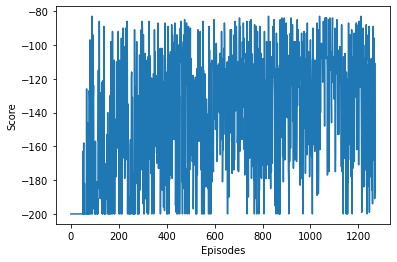

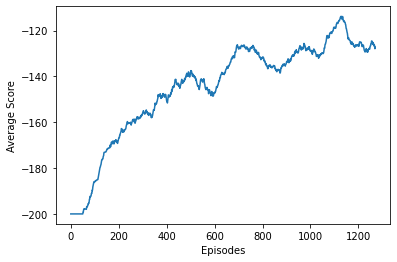

In [ ]:
trained_agent.plotting()

In [ ]:
def test(env,num_episodes):
        duelingdqn_agent.q_net.load_weights('model.h5')
        scores, avg_scores = [], []
        score = 0.0
        for i in range(num_episodes):
            state = env.reset()
            done = False
            episode_score = 0.0
            while not done:
                env.render()
                action = duelingdqn_agent.act(state)
                new_state, reward, done, _ = env.step(action)
                episode_score = episode_score + reward
                state = new_state
            score = score + episode_score
            scores.append(episode_score)
            episodes.append(i)
            avg_score = np.mean(scores[-100:])
            avg_scores.append(avg_score)

         #fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(avg_scores)), avg_scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        env.close()

In [ ]:
test(env, 1200)